In [1]:
#A point to point SMF Gaussian beam propagation through 2 lenses
#working wavelength for TC18APC-1550: 1465 - 1648 nm

import os
import sys
sys.path.append('..') 

import importlib
import modified_matrix_tracer
importlib.reload(modified_matrix_tracer)

from modified_matrix_tracer import GaussianBeam, FreeSpaceIterator, ThinLens, Misalignment
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from cycler import cycler
import numpy as np
import operator


#sample
Nsamples = 1000
scale = 1e3 #plot in um


#fibre
SMF28_fibre_para = {
"core_diameter": 8.2e-6,
"core_beam_x0":0,
"core_beam_theta":0,
"NA": 0.14
}

#lens
#lens
TC18APC1550_para = {
"focal" : 18.36e-3,
"clear_aperture" : 10e-3,
"outer_diameter" : 14.9e-3,
    "length": 33.5e-3,
#"wavelength_range": np.linspace(1465.0e-9, 1650.0e-9, num=38)
 "wavelength_range": [1465.0e-9, 1550.0e-9, 1648.0e-9],
 "MFD_mode_solver":[9.94746832156340e-6, 10.3988077139997e-6, 10.9710948505490e-6]
}




#10 colour keys
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color'] 


zmax_against_wavelength = []
RX_wr_vec = []

In [2]:
#The 5 step propgation between 2 lenses:

#ideal scenario
def ideal_p2p_propagation(beam, lens, z, focal_length, Nsamples):
    
    #1. From TX fibre to 1st lens, propagate a free space distance of focal length
    FreeSpaceIterator(beam, distance=focal_length, samples= Nsamples)
    #2. Pass through 1 st lens
    beam.propagate(lens)
    #3. Propagate a free space distance z
    FreeSpaceIterator(beam, distance=z, samples=Nsamples)
    
    #4. Pass through 2nd lens
    beam.propagate(lens)
    #5. Refocus to exit fibre end, propagate a free space distance of focal length
    FreeSpaceIterator(beam, distance=focal_length, samples= Nsamples)
    
    return beam

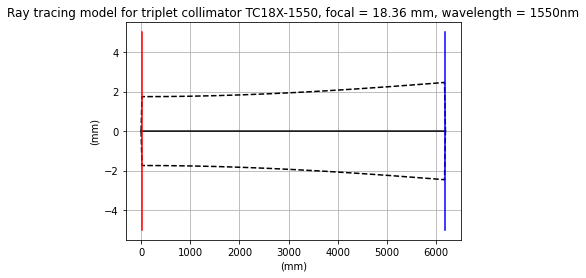


Exit MFD at 1550nm: 1.0398807714038995e-05


In [3]:


for wavelength, MFD in zip(TC18APC1550_para["wavelength_range"], TC18APC1550_para["MFD_mode_solver"]):
    
   #Gaussian beam SMF centre core located at x  = 0, theta = 0
    core_beam = GaussianBeam(SMF28_fibre_para["core_beam_x0"], SMF28_fibre_para["core_beam_theta"], MFD, wavelength)
    
    #Triplet collimator TC18X-1550, focal = 18.36 mm
    TC18APC1550 = ThinLens(TC18APC1550_para["focal"])
    #theoretical maximum working distance to maintain collimation
    zmax = TC18APC1550.lens_maximum_working_distance(TC18APC1550_para["focal"], wavelength, MFD) #meters
    #append in vector
    zmax_against_wavelength.append(zmax)
    
    lens1_location = TC18APC1550_para["focal"]
    lens2_location = TC18APC1550_para["focal"] + zmax
  


    
    
    #propagate the ideal process of p2p link
    core_beam = ideal_p2p_propagation(core_beam, TC18APC1550, zmax, TC18APC1550_para["focal"], Nsamples)
    

    
    #The beam radius fed into RX fibre
    RX_wr = core_beam.beam_radius_upper()[-1]
    RX_wr_vec.append(RX_wr)
    
          

    #plot the scenario for 1550nm 
    if wavelength == 1550e-09:
    
              
        # Plotting
        plt.figure()
        plt.plot(scale*np.array(core_beam.centre_ray.z_distance), scale *
                np.array(core_beam.beam_radius_upper()), color='black', linestyle='--')
        plt.plot(scale*np.array(core_beam.centre_ray.z_distance), scale *
                np.array(core_beam.beam_radius_lower()), color='black', linestyle='--')
        plt.plot(scale*np.array(core_beam.centre_ray.z_distance),
                [scale*i[0, 0] for i in core_beam.centre_ray.vector], color='black')


        # Plot lens positions
        # 10mm lens width
        # see https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=5124
        aperture_y = np.array([1, -1])*TC18APC1550_para["clear_aperture"]/2
        aperture_x = np.array([1, 1])
        plt.plot(aperture_x*lens1_location*scale, aperture_y*scale, color='red')
        plt.plot(aperture_x*lens2_location*scale, aperture_y*scale, color='blue')
        plt.xlabel('(mm)')
        plt.ylabel('(mm)')
        plt.grid()
        plt.title('Ray tracing model for triplet collimator TC18X-1550, focal = 18.36 mm, wavelength = 1550nm')
        plt.show()
        
        
        
        print()
        exit_MFD = core_beam.beam_radius_upper()[-1] - core_beam.beam_radius_lower()[-1]
        print("Exit MFD at 1550nm: {}".format(exit_MFD))
        
        

    
    